In [2]:
!kaggle datasets download -q yiweilu2033/well-documented-alzheimers-dataset

Dataset URL: https://www.kaggle.com/datasets/yiweilu2033/well-documented-alzheimers-dataset
License(s): Attribution 4.0 International (CC BY 4.0)


In [3]:
!unzip -q ./well-documented-alzheimers-dataset.zip

In [4]:
!mv "NonDemented (2)" NonDemented

In [5]:
!mv NonDemented ImgDataset
!mv VeryMildDemented ImgDataset
!mv MildDemented ImgDataset
!mv ModerateDemented ImgDataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import PIL
import time
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, random_split
import torch.nn.functional as F
from torchvision import datasets, transforms

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root='./ImgDataset', transform=transform)

train_size = int(0.70 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

torch.manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

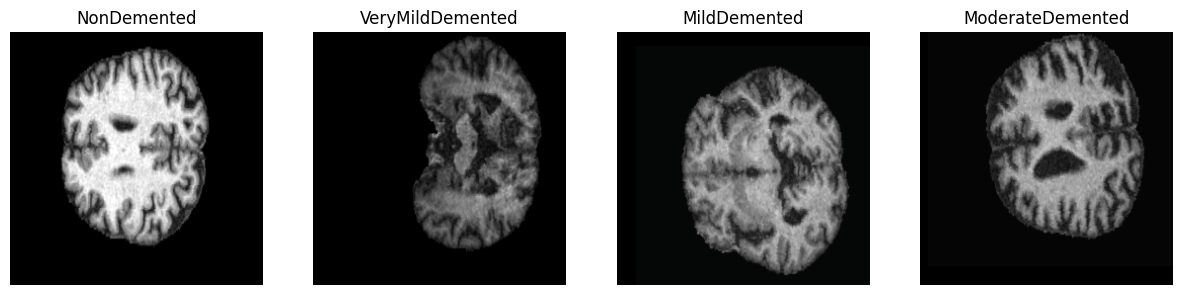

In [8]:
class_images = {}
for images, labels in train_loader:
    for i in range(len(labels)):
        label = labels[i].item()
        if label not in class_images:
            class_images[label] = images[i]
    if len(class_images) == len(train_loader.dataset.dataset.classes):
        break

fig, axs = plt.subplots(1, len(class_images), figsize=(15, 5))
for i, (label, image) in enumerate(class_images.items()):
    image_np = image.permute(1, 2, 0).numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)

    axs[i].imshow(image_np)
    axs[i].set_title(train_loader.dataset.dataset.classes[label])
    axs[i].axis('off')
plt.show()

In [9]:
class AlzheimerCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(AlzheimerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d((2, 2), stride=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu((self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu((self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(F.relu((self.conv5(x))))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AlzheimerCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

def train_val_loop(epochs, patience):
    best_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    avg_train_losses = []
    
    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        avg_train_losses.append(avg_loss)

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Time: {epoch_time:.2f} seconds")

        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_acc = 100 * correct / total
        print(f"Validation Accuracy: {val_acc:.2f}%")

        scheduler.step(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"New best model saved at epoch {epoch+1} with accuracy {val_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best model at epoch {best_epoch+1} with accuracy {best_acc:.2f}%")
            break

    total_end_time = time.time()
    total_time = total_end_time - total_start_time
    print(f"Total training time: {total_time:.2f} seconds")

    return avg_train_losses, all_labels, all_preds

avg_train_losses, all_labels, all_preds = train_val_loop(epochs=100, patience=7)

Epoch 1/100, Loss: 0.4903, Time: 290.63 seconds
Validation Accuracy: 78.43%
New best model saved at epoch 1 with accuracy 78.43%
Epoch 2/100, Loss: 0.4471, Time: 287.79 seconds
Validation Accuracy: 78.83%
New best model saved at epoch 2 with accuracy 78.83%
Epoch 3/100, Loss: 0.4302, Time: 287.97 seconds
Validation Accuracy: 79.71%
New best model saved at epoch 3 with accuracy 79.71%
Epoch 4/100, Loss: 0.4119, Time: 288.41 seconds
Validation Accuracy: 80.73%
New best model saved at epoch 4 with accuracy 80.73%
Epoch 5/100, Loss: 0.3964, Time: 289.48 seconds
Validation Accuracy: 79.08%
No improvement for 1 epochs.
Epoch 6/100, Loss: 0.3774, Time: 288.33 seconds
Validation Accuracy: 82.81%
New best model saved at epoch 6 with accuracy 82.81%
Epoch 7/100, Loss: 0.3544, Time: 288.46 seconds
Validation Accuracy: 83.98%
New best model saved at epoch 7 with accuracy 83.98%
Epoch 8/100, Loss: 0.3295, Time: 288.15 seconds
Validation Accuracy: 85.52%
New best model saved at epoch 8 with accuracy

In [10]:
with torch.no_grad():
    all_test_labels = []
    all_test_preds = []
    for inputs, labels in test_loader:
        model.eval()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

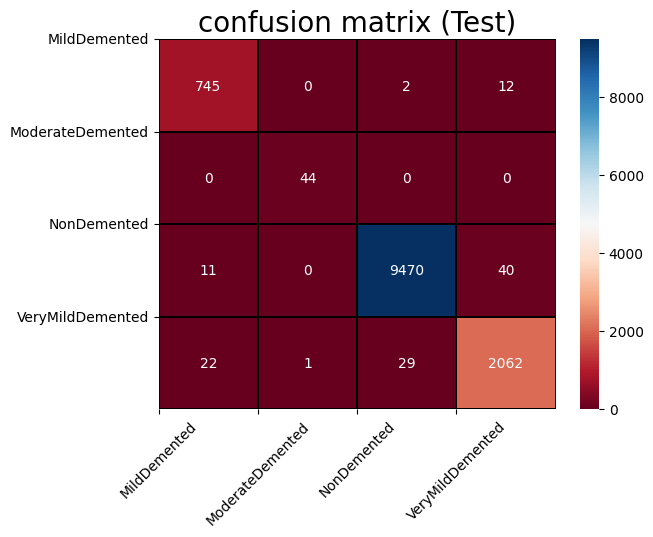

In [52]:
sns.heatmap(confusion_matrix(all_test_preds, all_test_labels), annot = True, fmt='.0f', cmap = 'RdBu', linecolor = 'black', lw = 0.2)
plt.title("confusion matrix (Test)", size = 20)
plt.xticks(ticks=range(len(dataset.classes)), labels=dataset.classes, rotation=45)
plt.yticks(ticks=range(len(dataset.classes)), labels=dataset.classes, rotation=0)
plt.show()

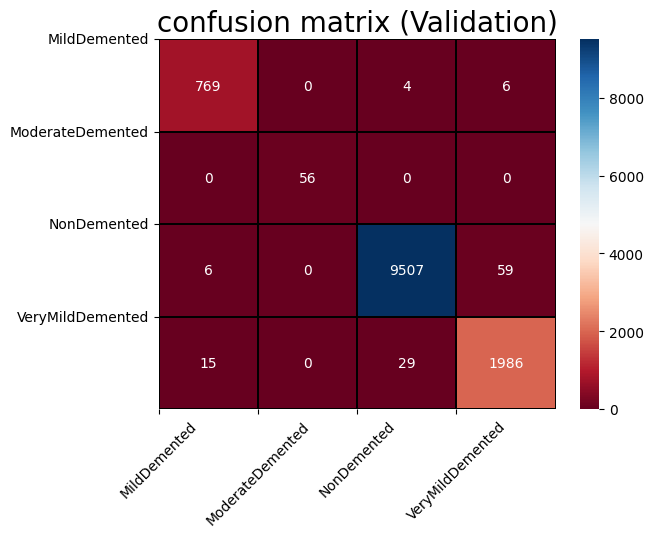

In [51]:
sns.heatmap(confusion_matrix(all_preds, all_labels), annot = True, fmt='.0f', cmap = 'RdBu', linecolor = 'black', lw = 0.2)
plt.title("confusion matrix (Validation)", size = 20)
plt.xticks(ticks=range(len(dataset.classes)), labels=dataset.classes, rotation=45)
plt.yticks(ticks=range(len(dataset.classes)), labels=dataset.classes, rotation=0)
plt.show()

In [56]:
print("|-------------------------Test Classification Report (Test)---------|")
print(classification_report(all_test_preds, all_test_labels))
print("|-------------------------------------------------------------------|")

|-------------------------Test Classification Report (Test)---------|
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       759
           1       0.98      1.00      0.99        44
           2       1.00      0.99      1.00      9521
           3       0.98      0.98      0.98      2114

    accuracy                           0.99     12438
   macro avg       0.98      0.99      0.98     12438
weighted avg       0.99      0.99      0.99     12438

|-------------------------------------------------------------------|


In [55]:
print("|-------------------------Test Classification Report (Validation)---------|")
print(classification_report(all_preds, all_labels))
print("|-------------------------------------------------------------------------|")

|-------------------------Test Classification Report (Validation)---------|
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       779
           1       1.00      1.00      1.00        56
           2       1.00      0.99      0.99      9572
           3       0.97      0.98      0.97      2030

    accuracy                           0.99     12437
   macro avg       0.98      0.99      0.99     12437
weighted avg       0.99      0.99      0.99     12437

|-------------------------------------------------------------------------|


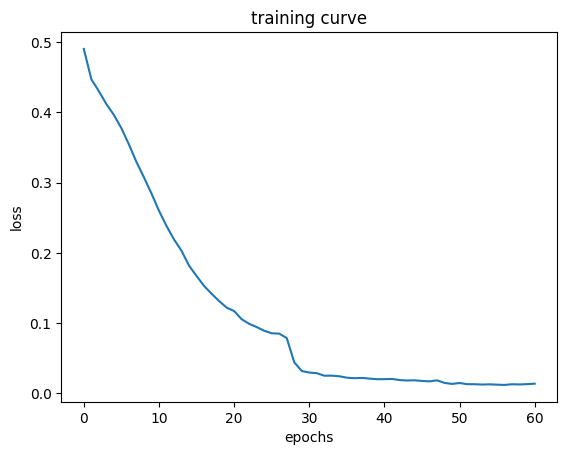

In [31]:
plt.plot(avg_train_losses)
plt.title('training curve')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

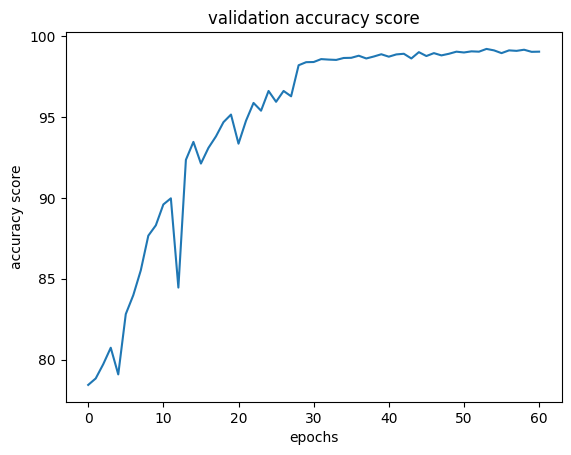

In [62]:
validation_accuracy = [
    78.43, 78.83, 79.71, 80.73, 79.08, 82.81, 83.98, 85.52, 87.66, 88.30,
    89.59, 89.97, 84.45, 92.35, 93.46, 92.12, 93.09, 93.80, 94.68, 95.15,
    93.35, 94.77, 95.87, 95.39, 96.61, 95.94, 96.61, 96.28, 98.20, 98.39,
    98.40, 98.58, 98.55, 98.53, 98.65, 98.66, 98.79, 98.62, 98.74, 98.88,
    98.73, 98.87, 98.91, 98.62, 99.01, 98.77, 98.95, 98.81, 98.91, 99.04,
    98.99, 99.06, 99.04, 99.21, 99.12, 98.95, 99.12, 99.09, 99.16, 99.03,
    99.04
]

plt.plot(validation_accuracy)
plt.title("validation accuracy score")
plt.xlabel("epochs")
plt.ylabel("accuracy score")
plt.show()

In [221]:
def get_output(input_img):
    probabilities = nn.functional.softmax(model.to('cpu')(input_img)[0], dim=0).detach().numpy()
    classes = [str(i) for i in np.array(dataset.classes)]
    bars = plt.bar(classes, probabilities)
    for bar, prob in zip(bars, probabilities):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{prob*100:.2f}', ha='center', va='bottom')
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.title('Probability Distribution Across Classes')
    plt.xticks(rotation=45)
    plt.show()

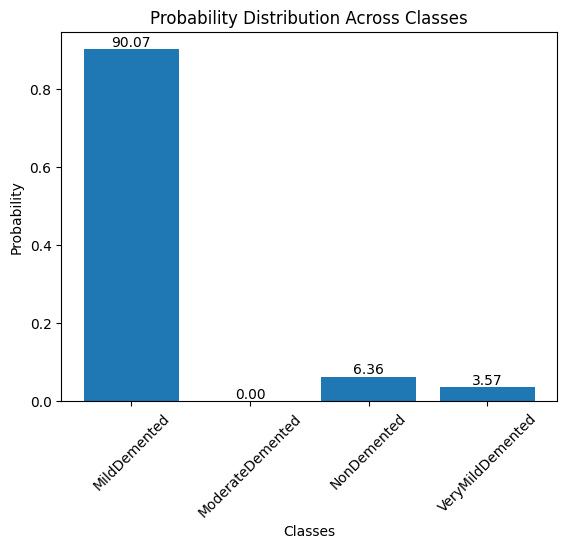

In [222]:
get_output(test_loader.dataset.dataset[0][0].unsqueeze(0))

In [1]:
torch.save(model, 'alzheimer-model.pth')

NameError: name 'torch' is not defined